# Chapter 3: Classification

In [1]:
import numpy as np

## 3.1 MNIST

`MNIST dataset` is a dataset of small images of handwritten digits. Very popular and is the "hello world", introductory dataset of Machine Learning.

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

There are `70,000 images` and each image has `784 features (28 pixels * 28 pixels)`, and each feature = pixel intensity (0, white -> 255, black).

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

- Use `.iloc[]` for row indexing
- `"X[0]"` in book causes error since that defaults to column indexing


- Use `.values.reshape()` for Scikit-Learn Series reshaping  
- `.reshape(28, 28)` is depreciated in official docs


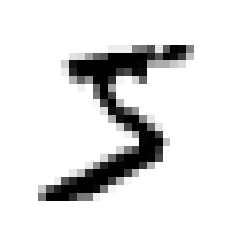

In [7]:
some_digit = X.iloc[0]
some_digit_image = some_digit.values.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [8]:
y[0]

'5'

In [9]:
y = y.astype(np.uint8)
y[0]

5

Dataset has already split `training set (0:60,000)` and `test set (60,000:)`.  
Training set has also been shuffled already.

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 Training a Binary Classifier

Let's try to identify one digit - 5.  Construct a booleran array of which True means 5, False otherwise.

In [11]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Use Scikit-Learn's `SGDClassifier (Stochastic Gradient Descent)`.

In [12]:
from sklearn.linear_model import SGDClassifier

Set `random_state` parameter to remove randomness.

In [13]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

## 3.3 Performance Measures

### 3.3.1 Measuring Accuracy Using Cross-Validation

In some cases, creating own cross-valid set gives more control than Scikit-learn.

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

Note: `random_state=42` is not needed since shuffle is off by default.

In [16]:
skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.9502, 0.96565, and 0.96495

0.95035
0.96035
0.9604


Using Scikit-Learn's `cross_val_score()` to evalue the SGDClassifier.

In [17]:
from sklearn.model_selection import cross_val_score

In [18]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Let's compare to those in the 'not 5' class.

In [19]:
from sklearn.base import BaseEstimator

In [20]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

About 90% accurate to predicting not 5.  

`Recall: We constructed a binary classifier. It is a 5 or not 5.`  

Since only 10% of dataset are 5s, if we always guess image is not 5, we get right about 90% of the time.

### 3.3.2 Confusion Matrix

To evaluate performance of classifier, look at `confusion matrix` and count number of times instances of Class A are classified as Class B.  

Use `cross_val_predict()` to compare, leaving test set untouched.

In [22]:
from sklearn.model_selection import cross_val_predict

In [23]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [24]:
from sklearn.metrics import confusion_matrix

Each row represents an actual class, while each column represents a predicted class.  

1,1 : correct non-5 images or `true negatives`  
1,2 : wrong non-5 images or `false positives`  
2,1 : wrong 5 images or `false positives`  
2,2 : correct 5 images or `true positives`

In [25]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

A perfect confusion matrix would only have true positives and true negatives.  
Off-diagonal = 0

In [26]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

Equation 3-1. Precision  

$$ precision = \frac{TP}{TP + FP}$$ where TP = `true positives` and FP = `false positives`

Equation 3-2. Recall  

$$ recall = \frac{TP}{TP + FN} $$

where TP = `true positives` and FN = `false negatives`

### 3.3.3 Precision and Recall

Scikit-Learn provides `precision_score` and `recall_score`.

In [27]:
from sklearn.metrics import precision_score, recall_score

In [28]:
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522) for book
                                         # == 3530 / (3530 + 687) for me

0.8370879772350012

In [29]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325) for book
                                      # == 3530 / (3530 + 1891) for me

0.6511713705958311

It is only correct 83% of the time, and only detects 65% of the 5s.

A better metric would be the $F_{1}$ score, the harmonic mean of precision and recall, `more weight to low values`.  

$\uparrow$$\uparrow$ $F_{1}$ scores only if $\uparrow$$\uparrow$ recall and $\uparrow$$\uparrow$ precision.

Equation 3-3. $F_{1}$

$$ F_{1} = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2\frac{precision * recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}$$

In [30]:
from sklearn.metrics import f1_score

In [31]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 3.3.4 Precision/Recall Trade-Off

SCGDClassifier makes classification based on a `decision function` scoring.  
If score > threshold, positive class.  
If score < threshold, negative class. 

$\uparrow$ threshold = $\uparrow$ accuracy, $\downarrow$ recall  
$\downarrow$ threshold = $\downarrow$ accuracy, $\uparrow$ recall  

Scikit-Learn doesn't allow setting threshold directly, but can use `decision_function()` to return a score for each instance.

In [32]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [33]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [34]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Since `some_digit == 5`, increasing the threshold returns `False` meaning it decreasing the recall.

Which threshold to use?  
Use `cross_val_predict()` and specify in parameter to return decision scores.

In [35]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

With decision scores in `y_scores`, use `precision_recall_curve()` to compute for all possible thresholds.

In [36]:
from sklearn.metrics import precision_recall_curve

In [37]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Use `Matplotlib` to plot precision and recall as functions of threshold value.

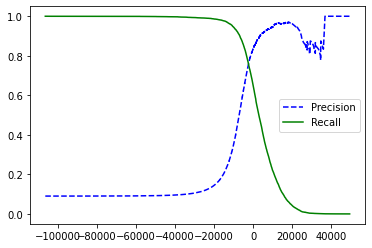

In [38]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(["Precision", "Recall"])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

`Note: Precision may sometimes go down when threshold is raised (but in general, it goes up).`

`To find lowest threshold that gives 90% precision`, use `np.argmax()` to find the first index of the maximum value - the 1st True value in this example).

In [39]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816

Now make predictions on training set and see the precision and recall scores.

In [40]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [41]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### 3.3.5 The ROC Curve

The `receiver operating characteristic (ROC) curve` is another common tool used with binary classifiers. It plots the `true positive rate (recall)` against the `false positive rate (FPR)`. The FPR is the ratio of negative instances that are incorrectly classified as positive.  

To plot ROC curve, use `roc_curve()` to compute TPR and FPR for various threshold values.

In [42]:
from sklearn.metrics import roc_curve

In [43]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

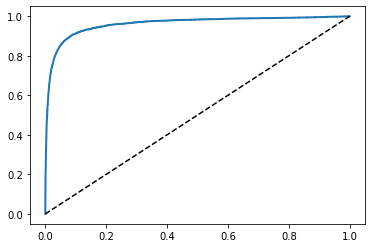

In [44]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal

plot_roc_curve(fpr, tpr)
plt.show()

Note: the $\uparrow$ the recall (TPR/y-axis), $\uparrow$ false positives (FPR/x-axis).  

The dotted line represents the ROC curve of a purely random classifier. `A good classifier stays as far away from that dotted line as possible (towards top-left corner is good).`

One way to compare classifiers is to measure the `area under the curve (AUC)`.  

A perfect classifier will have `AUC = 1`.  
A purely random classifier will have `AUC = 0.5`.

In [45]:
from sklearn.metrics import roc_auc_score

In [46]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Rule of thumb: you should prefer the PR curve whenever:  
- `The positive class is rare`  
- `You care more about the false positives than false negatives`

Otherwise, use ROC curve.

Now let's train RandomForestClassifier and compare ROC curve and AUC score to SGDClassifier.  

RandomForestClassifier does not have decision_function() but does have `predict_proba()` method, which returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class.

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

roc_curve() expects labels and scores but you can give it class probabilities instead of scores.

In [49]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

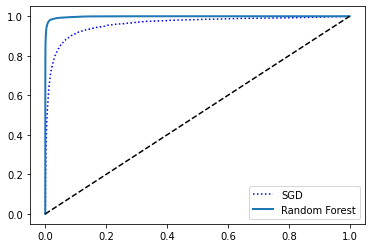

In [50]:
plt.plot(fpr, tpr, "b:", label="SGD") # First ROC curve for comparison
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [51]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Comparing ROC curves, Random Forest Classifier is superior to SGD classifier because its ROC curve is:  
- Much closer to the top-left corner  
- Has a greater AUC (0.998 vs. 0.960)

## 3.4 Multiclass Classification

To create a system that can classify the digit images into 10 classes (0-9):  
- `One-versus-the-rest (OvR) / One-versus-all (OvA)`:  
    - Train 10 binary classifier, one for each digit
    - Get the decision score from each classifier then select the class whose classifier outputs highest score
- `One-versus-one (OvO)`:  
    - Train a binary classifier for every pair of digits
    - If N classes, $\frac{N(N-1)}{2}$ classifers  

Scikit-Learn automatically runs OvR or OvO depending on the algorithm.

In [52]:
from sklearn.svm import SVC

This trains the SVC on training set using original target classes 0-9 (y_train), makes prediction using OvO strategy - training 45 binary classifiers, get decision scores, and select class that won the most duels.

In [53]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [54]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [55]:
np.argmax(some_digit_scores)

5

When a classifier is trained, it stores the list of target classes in its `classes_` attribute, ordered by value.

In [56]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [57]:
svm_clf.classes_[5]

5

Use `OneVsOneClassifier` or `OneVsRestClassifier` classes to force Scikit-Learn.  

1. Create an instance
2. Pass a classifier to its constructor (does not need to be a binary classifier)

In [58]:
from sklearn.multiclass import OneVsRestClassifier

In [59]:
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42)) 
# Parameters specified in accompanying Jupyter notebook
ovr_clf.fit(X_train[:1000], y_train[:1000]) 
# Only take the 1st 1000 training samples
# This should allow OvR with SVC to run much faster, ie. less to compute
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [60]:
len(ovr_clf.estimators_)

10

Similarly for training SGDClassifier or RandomForestClassifier.  

`Note: Previously we trained SGDClassifier using y_train_5 (binary-5 matrix), now we train on y_train (0-9).`  

Scikit-Learn does not run OvR or OvO because SGD classifiers can directly classify instances into multiple classes.

In [61]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [62]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

`Note: It wrongly classified the 1st image (some_digit) as 3 (1823 score). There is a bug on Scikit-Learn and alters the results.`  

- In accompanying Jupyter notebook, it also wrongly classifies as 3 (1823 score) and 5 (-1385).  
- In book, it rightly classifies as 5 (2412.5 score) and 3 (573.5). But mentions that has a slight doubt towards 3.  

Use `cross_val_score()` to evaluate this SGDClassifier's accuracy.

In [63]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

It got over 84% accuracy on all 3 test folds.  

`Recall: This is ~84% accuracy that it classifies as 3, meaning the SGDClassifier is a worse classifier than SVC.`

In [64]:
from sklearn.preprocessing import StandardScaler

A random classifier would get 10% accuracy.  
Scaling the inputs increases accuracy above 89%.

In [65]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 3.5 Error Analysis

Once data preparation is complete and found a promising model, analyze the type of errors it makes.  

1. Look at the confusion matrix.

In [66]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

More convenient to look at an image representation of the confusion matrix, using Matplotlib's `matshow()` function.

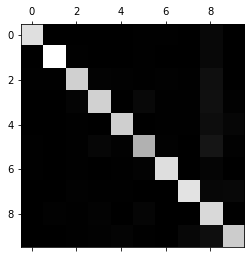

In [67]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

$\uparrow$ confusion matrix value = more white.  

`Recall: rows = classes, columns = predictions. So row 0 predicted many 0's (white) and very few of any other numbers (black).`

Looking at the plot, most of the images (more white) are on the diagonal meaning it was classified correctly.  

But focus on the plot on errors. Divide each value in the confusion matrix by number of images in corresponding class to compare error rates instead of absolute errors.

In [68]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Fill diagonal with 0's to keep only errors and plot result.  

`Note: Want to highlight error rate, so no error (black) and high error rate (white).`

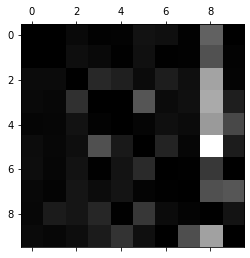

In [69]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Column 8 is quite bright => many images get misclassified as 8's.  
However, Row for class 8 is not => actual 8's are properly classified as 8's.  
May be worthy to spend time on reducing the false 8's.  

`Analyzing individual errors can be a good way to gain insight on what classifier is doing and why it's failing but difficult and time consuming.`  

Let's plot examples of 3's and 5's using `plot_digits()` - which just uses Matplotlib's `imshow()`.

In [102]:
# NOTE: COPIED FROM ACCOMPANYING JUPYTER NOTEBOOK
# NOTE: Added '.values' to .reshape as .reshape has been depreciated
# NOTE: Added _, and '.iterrows()' to iterate dataframe columns=_ and rows=instance

# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.values.reshape(size,size) for _, instance in instances.iterrows()]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

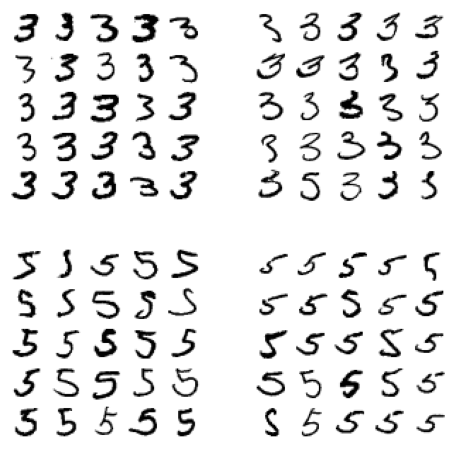

In [104]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

# plot_digits code only found in accompanying Jupyter Notebook
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[0:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[0:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[0:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[0:25], images_per_row=5)
plt.show()

Blocks on the left classified as 3's.  
Blocks on the right classified as 5's.  
Bottom-left and Top-right blocks are ones that are wrongly classified. 

SGDClassifier is a linear model and assigns a weight per class to each pixel. So for a new image, it sums up weighted pixel intensities to get a score for each class. 3's and 5's differ by a few pixels so model is easily confused.  

This classifier is sensitive to image shifting and rotation. To help reduce 3/5 confusion, ensure images are well centered and not too rotated.

## 3.6 Multilabel Classification

So far each instance has been assigned to just one class.  
Suppose a classifier has been trained to recognize 3 faces, Alice, Bob, and Charlie. Then when classifier is shown a picture of Alice and Charlie, it should output:  
 \[1, 0, 1] ("Alice yes, Bob no, Charlie yes").  

A `multilabel classification system` outputs multiple binary tags.

In [105]:
from sklearn.neighbors import KNeighborsClassifier

In [106]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [107]:
knn_clf.predict([some_digit])

array([[False,  True]])

some_digit (5) is indeed not large (False) and odd (True).

There are many ways to evaluate a multilabel classifier and select the right metric. One approach is to measure the $F_1$ score for each individual label then compute average score.  

This assumes all labels are equally important. If you have more pictures of Alice than Bob or Charlie, you may want to give more weight to classifier's score on pictures of Alice.  

One option is to give each label a weight equal to its `support, the number of instances with that target label`. To do this, set `average="weighted"`.

In [123]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## 3.7 Multioutput Classification

`Multioutput-multiclass classification (multioutput classification)` is a generalization of multilabel classification where each label can be multiclass ($>2$ possible values).  

Let's build a system to remove noise from images.  
`Note: The classifier's output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity 0-255).`  

Let's start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities using NumPy's `randint()`. Target images will be original images.

In [108]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

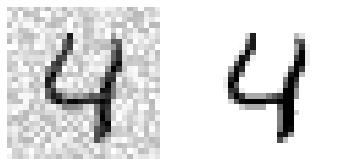

In [119]:
# NOTE: COPIED FROM ACCOMPANYING JUPYTER NOTEBOOK
# NOTE: Added .values to .reshape
# NOTE: Added .iloc to DataFrame indexing
# NOTE: some_index = 4 to copy book's representation

def plot_digit(data):
    image = data.values.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

some_index = 4
plt.subplot(121); plot_digit(X_test_mod.iloc[some_index])
plt.subplot(122); plot_digit(y_test_mod.iloc[some_index])
plt.show()

This is correct: left is noisy input image, right is clearn target image.

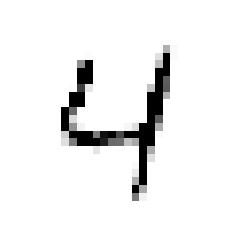

In [122]:
# NOTE: Removed .values because clean_digit is np array
# NOTE: Added .iloc to X_test_mod dataframe

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[some_index]])
plot_digit(clean_digit)